In [2]:
from transformer.transformer_old import *


Imported Transformer


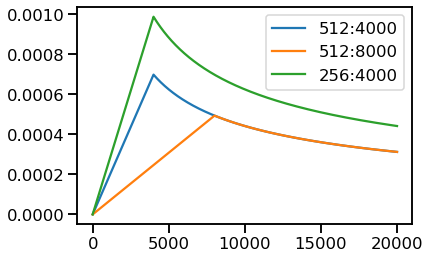

In [4]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

In [5]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

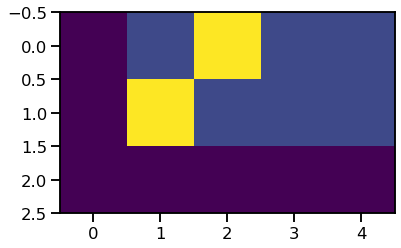

In [6]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

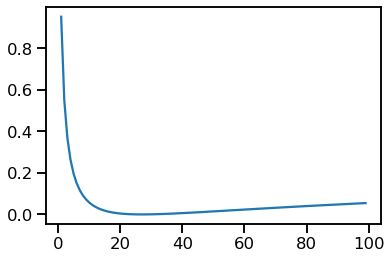

In [7]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).item()
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

# Example
This example is a copy-paste task

In [8]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [18]:
data = data_gen(11, 30, 5)
for item in data:
    print(item.src[0])
    print(item.trg[0])
    print(item.src)

tensor([ 1,  9,  9, 10,  1,  9, 10,  8,  4,  3])
tensor([ 1,  9,  9, 10,  1,  9, 10,  8,  4])
tensor([ 1,  6, 10, 10,  3,  3, 10,  6,  3,  4])
tensor([ 1,  6, 10, 10,  3,  3, 10,  6,  3])
tensor([1, 1, 3, 7, 3, 2, 7, 2, 7, 8])
tensor([1, 1, 3, 7, 3, 2, 7, 2, 7])
tensor([ 1,  5,  2,  6, 10,  4,  2,  1,  8,  7])
tensor([ 1,  5,  2,  6, 10,  4,  2,  1,  8])
tensor([1, 2, 2, 6, 8, 6, 3, 6, 1, 2])
tensor([1, 2, 2, 6, 8, 6, 3, 6, 1])


In [9]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

In [14]:
# Train the simple copy task (CPU)
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

Epoch Step: 1 Loss: 3.071786 Tokens per Sec: 1518.678833
Epoch Step: 1 Loss: 1.878656 Tokens per Sec: 2283.210449
tensor(1.8806)
Epoch Step: 1 Loss: 1.896112 Tokens per Sec: 1709.255493
Epoch Step: 1 Loss: 1.639931 Tokens per Sec: 2061.343750
tensor(1.6205)
Epoch Step: 1 Loss: 1.839475 Tokens per Sec: 1476.264038
Epoch Step: 1 Loss: 1.451765 Tokens per Sec: 2330.806641
tensor(1.4575)
Epoch Step: 1 Loss: 1.583775 Tokens per Sec: 1795.287720
Epoch Step: 1 Loss: 1.312843 Tokens per Sec: 2411.556396
tensor(1.2848)
Epoch Step: 1 Loss: 1.415323 Tokens per Sec: 1752.386230
Epoch Step: 1 Loss: 0.902733 Tokens per Sec: 2384.143311
tensor(0.8785)
Epoch Step: 1 Loss: 0.956054 Tokens per Sec: 1772.193970
Epoch Step: 1 Loss: 0.597416 Tokens per Sec: 2162.171387
tensor(0.5336)
Epoch Step: 1 Loss: 0.741269 Tokens per Sec: 1643.670776
Epoch Step: 1 Loss: 0.302980 Tokens per Sec: 1913.855957
tensor(0.3059)
Epoch Step: 1 Loss: 0.532304 Tokens per Sec: 1794.565063
Epoch Step: 1 Loss: 0.238789 Tokens per 

In [1]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

NameError: name 'model' is not defined

In [11]:

# imports
import enum

from torch.nn import Transformer
import io
import torch
from torchtext.utils import download_from_url, extract_archive
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


In [18]:

# constants/enums
class Dataset(enum.Enum):
    PennTreebank = 0,
    WikiText2 = 1,
    WikiText103 = 2

class LanguageTask(enum.Enum):
    CausalLanuageModeling = 0,
    MaskedLanuageModeling = 1

class Segmentation(enum.Enum):
    Word = 0,
    Subword = 1
    Character = 2
    BPE = 3
    BBPE = 4
    BYTE = 5

# configure model
config = {
    "embedding_dimension": 200,
    "ff_dimension": 200,
    "n_attention_heads": 2,
    "n_encoder_layers": 2,
    "n_decoder_layers": 2,
    "dataset": Dataset.PennTreebank,
    "batch_size": 20,
    "eval_batch_size": 10,
}

# load training data
train_data, val_data, test_data, vocab = load_data()

# instantiate model

# training loop

# evaluation


36718lines [00:01, 25681.84lines/s]


In [17]:
# load trainging data
# change to use torchtext
def load_data():
    url = 'https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip'
    test_filepath, valid_filepath, train_filepath = extract_archive(download_from_url(url))
    tokenizer = get_tokenizer('basic_english')
    vocab = build_vocab_from_iterator(map(tokenizer,
                                        iter(io.open(train_filepath,
                                                    encoding="utf8")))) # should build from all text
    def data_process(raw_text_iter):
        data = [torch.tensor([vocab[token] for token in tokenizer(item)],
                            dtype=torch.long) for item in raw_text_iter]
        return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

    train_data = data_process(iter(io.open(train_filepath, encoding="utf8")))
    val_data = data_process(iter(io.open(valid_filepath, encoding="utf8")))
    test_data = data_process(iter(io.open(test_filepath, encoding="utf8")))

    return train_data, val_data, test_data, vocab


In [15]:
# load functions


# batch functions
def batchify(data, bsz):
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

def get_batch(batch_size, source, i):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

torch.Size([3, 2])